# 02 – Baseline Model: Logistic Regression

**Project:** Predictive Modeling for Drug Discovery via Virtual Screening  
**Student:** Milica Jeftić (ID: 89211255)  
**Date:** January 2026  
**Dataset:** Kaggle – Drug Discovery Virtual Screening Dataset

---

## Goal of This Notebook

This notebook establishes a **baseline logistic regression model** as a reference point for all subsequent models.
The objectives are:

1. **Load Preprocessed Data** – Import train/validation/test sets from notebook 01
2. **Train Baseline Model** – Fit logistic regression on training data
3. **Validate Performance** – Evaluate on validation set with comprehensive metrics
4. **Test Evaluation** – Final unbiased evaluation on held-out test set
5. **Baseline Summary** – Document strengths, limitations, and reference point

---

## Expected Outputs

- Baseline model performance metrics (accuracy, precision, recall, F1, ROC-AUC)
- Confusion matrix and ROC curve visualizations
- Saved baseline model (joblib)
- Baseline report (saved to `results/metrics/`)

---

## 1. Environment Setup

This section sets up the computational environment, imports required libraries, and defines global configuration used throughout the notebook to ensure reproducibility and consistency.

In [1]:
# ============================
# Environment & Configuration
# ============================

import os
import sys
import warnings

import numpy as np
import pandas as pd
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# ----------------------------
# Reproducibility & Warnings
# ----------------------------
np.random.seed(42)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# ----------------------------
# Pandas display options
# ----------------------------
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", 120)
pd.set_option("display.float_format", "{:.4f}".format)

# ----------------------------
# Visualization defaults
# ----------------------------
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

rcParams["figure.figsize"] = (12, 6)
rcParams["font.size"] = 12

%matplotlib inline

# ----------------------------
# Project paths
# ----------------------------
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

DATA_PROCESSED_PATH = os.path.join(PROJECT_ROOT, "data", "processed")
MODELS_PATH = os.path.join(PROJECT_ROOT, "models")
RESULTS_PATH = os.path.join(PROJECT_ROOT, "results")

print("=" * 60)
print("Environment initialized successfully")
print("=" * 60)
print(f"Python       : {sys.version.split()[0]}")
print(f"Numpy        : {np.__version__}")
print(f"Pandas       : {pd.__version__}")
print(f"Scikit-learn : {__import__('sklearn').__version__}")
print("-" * 60)
print(f"Project root : {PROJECT_ROOT}")
print(f"Data dir     : {DATA_PROCESSED_PATH}")
print(f"Models dir   : {MODELS_PATH}")
print("=" * 60)

Environment initialized successfully
Python       : 3.10.19
Numpy        : 2.2.5
Pandas       : 2.3.3
Scikit-learn : 1.7.2
------------------------------------------------------------
Project root : c:\Users\KORISNIK\Documents\drug-discovery-virtual-screening
Data dir     : c:\Users\KORISNIK\Documents\drug-discovery-virtual-screening\data\processed
Models dir   : c:\Users\KORISNIK\Documents\drug-discovery-virtual-screening\models


## 2. Load Preprocessed Data

We load the processed and scaled datasets from notebook 01.
These are ready for modeling—no further preprocessing is applied.

In [2]:
print("=" * 60)
print("LOADING PREPROCESSED DATA")
print("=" * 60)

# Load feature matrices
X_train = pd.read_csv(os.path.join(DATA_PROCESSED_PATH, "X_train.csv"))
X_val = pd.read_csv(os.path.join(DATA_PROCESSED_PATH, "X_val.csv"))
X_test = pd.read_csv(os.path.join(DATA_PROCESSED_PATH, "X_test.csv"))

# Load target vectors
y_train = pd.read_csv(os.path.join(DATA_PROCESSED_PATH, "y_train.csv")).squeeze("columns")
y_val = pd.read_csv(os.path.join(DATA_PROCESSED_PATH, "y_val.csv")).squeeze("columns")
y_test = pd.read_csv(os.path.join(DATA_PROCESSED_PATH, "y_test.csv")).squeeze("columns")

# Sanity checks
assert len(X_train) == len(y_train), "Train X/y length mismatch"
assert len(X_val) == len(y_val), "Val X/y length mismatch"
assert len(X_test) == len(y_test), "Test X/y length mismatch"

print(f"\n✓ Data loaded successfully")
print(f"\nTraining set:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"\nValidation set:")
print(f"  X_val:   {X_val.shape}")
print(f"  y_val:   {y_val.shape}")
print(f"\nTest set:")
print(f"  X_test:  {X_test.shape}")
print(f"  y_test:  {y_test.shape}")

# Verify class proportions across all sets
print(f"\nClass proportions (training set):")
print(y_train.value_counts(normalize=True))

print(f"\nClass proportions (validation set):")
print(y_val.value_counts(normalize=True))

print(f"\nClass proportions (test set):")
print(y_test.value_counts(normalize=True))

# Load scaler for pipeline continuity
scaler_path = os.path.join(MODELS_PATH, "standard_scaler.joblib")
if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
    print(f"\n✓ StandardScaler loaded from {scaler_path}")
else:
    print(f"\n Warning: Scaler not found at {scaler_path}")

LOADING PREPROCESSED DATA

✓ Data loaded successfully

Training set:
  X_train: (1278, 14)
  y_train: (1278,)

Validation set:
  X_val:   (274, 14)
  y_val:   (274,)

Test set:
  X_test:  (274, 14)
  y_test:  (274,)

Class proportions (training set):
active
0   0.6956
1   0.3044
Name: proportion, dtype: float64

Class proportions (validation set):
active
0   0.6934
1   0.3066
Name: proportion, dtype: float64

Class proportions (test set):
active
0   0.6971
1   0.3029
Name: proportion, dtype: float64

✓ StandardScaler loaded from c:\Users\KORISNIK\Documents\drug-discovery-virtual-screening\models\standard_scaler.joblib


## 3. Baseline Model: Logistic Regression

In this section, I initialize a Logistic Regression classifier to serve as an interpretable baseline.
This model provides a linear decision boundary and will be used as a reference point when comparing
more complex models later in the project.

In [3]:
print("=" * 60)
print("INITIALIZING BASELINE MODEL")
print("=" * 60)

# Initialize Logistic Regression with balanced weights
# to account for the class imbalance in the dataset
baseline_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

print(f"\n✓ Baseline model initialized")
print(f"\nModel parameters:")
print(f"  Algorithm       : Logistic Regression")
print(f"  Max iterations  : {baseline_model.max_iter}")
print(f"  Class weight    : {baseline_model.class_weight}")
print(f"  Solver          : {baseline_model.solver}")
print(f"  Random state    : {baseline_model.random_state}")
print(f"\nRationale:")
print(f"  • Linear baseline for interpretability")
print(f"  • Balanced weights to handle ~70/30 class imbalance")
print(f"  • Provides reference point for complex models")
print("=" * 60)

INITIALIZING BASELINE MODEL

✓ Baseline model initialized

Model parameters:
  Algorithm       : Logistic Regression
  Max iterations  : 1000
  Class weight    : balanced
  Solver          : lbfgs
  Random state    : 42

Rationale:
  • Linear baseline for interpretability
  • Balanced weights to handle ~70/30 class imbalance
  • Provides reference point for complex models


## 4. Training

This section trains the baseline model on the training dataset only.
No hyperparameter tuning or evaluation occurs here, only fitting.

In [4]:
import time

print("=" * 60)
print("TRAINING BASELINE MODEL")
print("=" * 60)

# Measure training time
start_time = time.time()

# Fit model on training data only
baseline_model.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time

print(f"\n✓ Model training completed")
print(f"\nTraining time: {training_time:.4f} seconds")
print(f"Training samples: {len(X_train)}")
print(f"Training features: {X_train.shape[1]}")
print("=" * 60)

TRAINING BASELINE MODEL

✓ Model training completed

Training time: 0.1399 seconds
Training samples: 1278
Training features: 14


## 5. Validation Evaluation

We evaluate the trained model on the validation set to measure its performance.
This uses multiple metrics (accuracy, precision, recall, F1, ROC-AUC) and visualizations.

In [5]:
print("=" * 60)
print("VALIDATION EVALUATION - METRICS")
print("=" * 60)

# Make predictions on validation set
y_val_pred = baseline_model.predict(X_val)
y_val_proba = baseline_model.predict_proba(X_val)[:, 1]

# Calculate metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_proba)

print(f"\n✓ Validation metrics calculated")
print(f"\nValidation Set Performance:")
print(f"  Accuracy  : {val_accuracy:.4f}")
print(f"  Precision : {val_precision:.4f}")
print(f"  Recall    : {val_recall:.4f}")
print(f"  F1-Score  : {val_f1:.4f}")
print(f"  ROC-AUC   : {val_roc_auc:.4f}")
print("=" * 60)

VALIDATION EVALUATION - METRICS

✓ Validation metrics calculated

Validation Set Performance:
  Accuracy  : 0.9818
  Precision : 0.9438
  Recall    : 1.0000
  F1-Score  : 0.9711
  ROC-AUC   : 0.9994


VALIDATION EVALUATION - VISUALIZATIONS

✓ Visualization saved to c:\Users\KORISNIK\Documents\drug-discovery-virtual-screening\results\figures\baseline_validation_evaluation.png


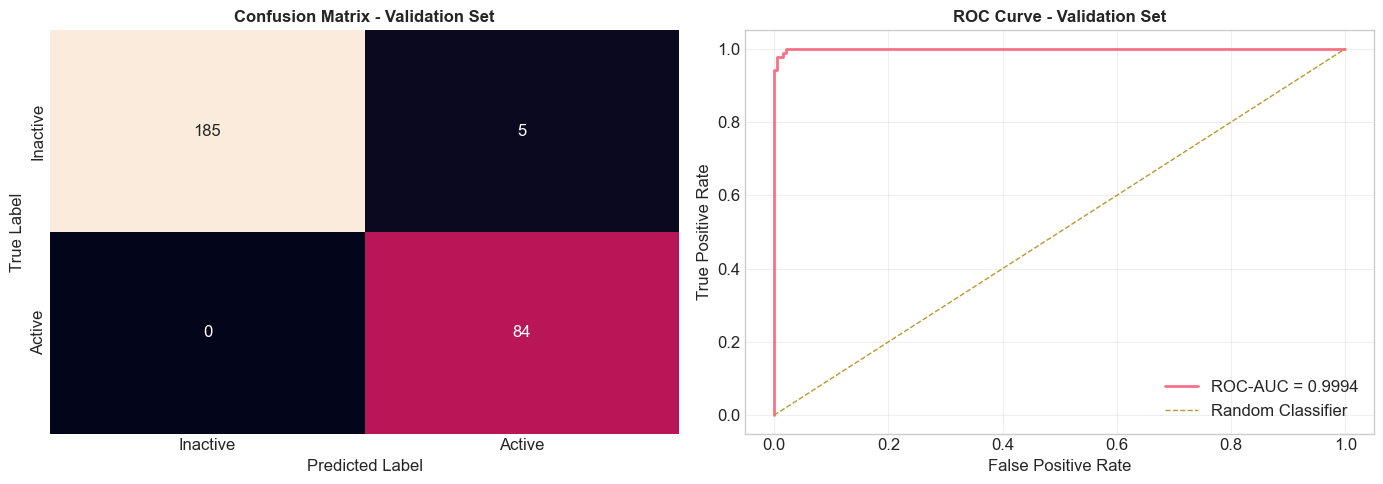

In [6]:
print("=" * 60)
print("VALIDATION EVALUATION - VISUALIZATIONS")
print("=" * 60)

# Compute confusion matrix and ROC curve
cm = confusion_matrix(y_val, y_val_pred)
fpr, tpr, _ = roc_curve(y_val, y_val_proba)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Confusion Matrix
sns.heatmap(
    cm, annot=True, fmt="d", ax=axes[0], cbar=False,
    xticklabels=["Inactive", "Active"],
    yticklabels=["Inactive", "Active"]
)
axes[0].set_title("Confusion Matrix - Validation Set", fontsize=12, fontweight="bold")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")

# Subplot 2: ROC Curve
axes[1].plot(fpr, tpr, linewidth=2, label=f"ROC-AUC = {val_roc_auc:.4f}")
axes[1].plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Random Classifier")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve - Validation Set", fontsize=12, fontweight="bold")
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
figures_path = os.path.join(RESULTS_PATH, "figures")
os.makedirs(figures_path, exist_ok=True)
fig_path = os.path.join(figures_path, "baseline_validation_evaluation.png")
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
print(f"\n✓ Visualization saved to {fig_path}")

plt.show()

## 6. Test Evaluation

We evaluate the trained model on the held-out test set for final, unbiased performance assessment.
This uses the same metrics and visualizations as validation for direct comparison.

In [8]:
print("=" * 60)
print("TEST EVALUATION - METRICS")
print("=" * 60)

# Make predictions on test set
y_test_pred = baseline_model.predict(X_test)
y_test_proba = baseline_model.predict_proba(X_test)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"\n✓ Test metrics calculated")
print(f"\nTest Set Performance:")
print(f"  Accuracy  : {test_accuracy:.4f}")
print(f"  Precision : {test_precision:.4f}")
print(f"  Recall    : {test_recall:.4f}")
print(f"  F1-Score  : {test_f1:.4f}")
print(f"  ROC-AUC   : {test_roc_auc:.4f}")
print("=" * 60)


TEST EVALUATION - METRICS

✓ Test metrics calculated

Test Set Performance:
  Accuracy  : 0.9891
  Precision : 0.9651
  Recall    : 1.0000
  F1-Score  : 0.9822
  ROC-AUC   : 0.9998


TEST EVALUATION - VISUALIZATIONS

✓ Visualization saved to c:\Users\KORISNIK\Documents\drug-discovery-virtual-screening\results\figures\baseline_test_evaluation.png


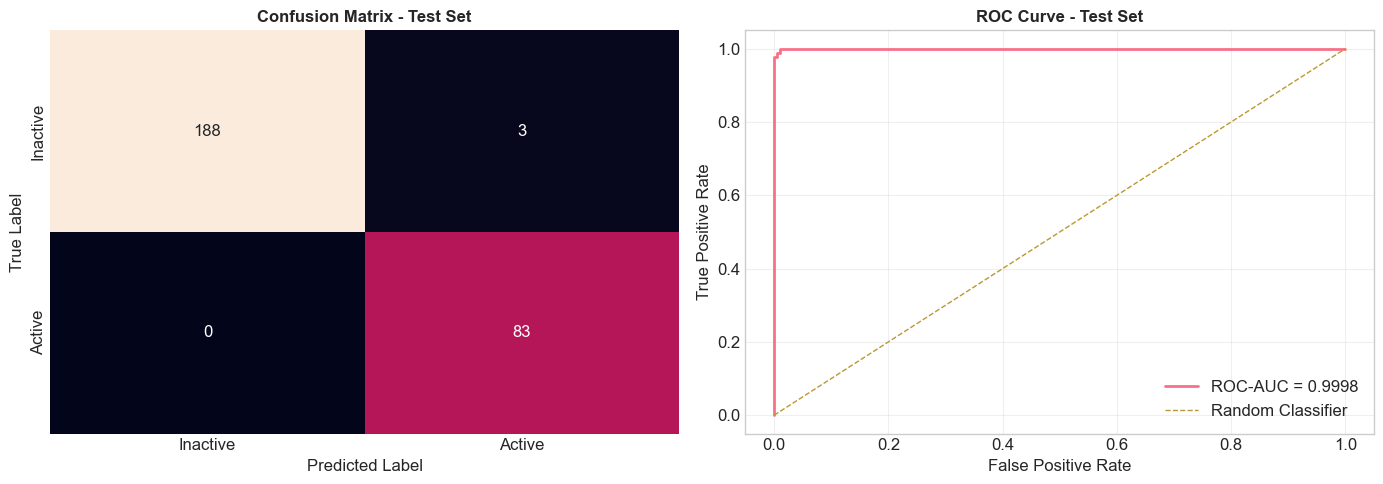

In [9]:
print("=" * 60)
print("TEST EVALUATION - VISUALIZATIONS")
print("=" * 60)

# Compute confusion matrix and ROC curve
cm_test = confusion_matrix(y_test, y_test_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Confusion Matrix
sns.heatmap(
    cm_test, annot=True, fmt="d", ax=axes[0], cbar=False,
    xticklabels=["Inactive", "Active"],
    yticklabels=["Inactive", "Active"]
)
axes[0].set_title("Confusion Matrix - Test Set", fontsize=12, fontweight="bold")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")

# Subplot 2: ROC Curve
axes[1].plot(fpr_test, tpr_test, linewidth=2, label=f"ROC-AUC = {test_roc_auc:.4f}")
axes[1].plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Random Classifier")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve - Test Set", fontsize=12, fontweight="bold")
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

# Save figure (will remain local if results/* is ignored)
figures_path = os.path.join(RESULTS_PATH, "figures")
os.makedirs(figures_path, exist_ok=True)
fig_path = os.path.join(figures_path, "baseline_test_evaluation.png")
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
print(f"\n✓ Visualization saved to {fig_path}")

plt.show()
